# Face Mask Detection — EDA and baseline classification
Imports and environment setup for analysis and baseline model training.

This notebook covers:
- Dataset scan and stratified splits
- Transforms and DataLoader
- MobileNetV2 baseline training
- Metrics, inference, and ONNX export

In [ ]:
# Imports
# Core libs, plotting, ML stack, ONNX runtime, and utilities
import os
import random
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import onnx
import onnxruntime as ort
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Reproducibility (best-effort): sets seeds for numpy/torch and non-deterministic ops
# Note: full determinism may require disabling certain CUDA ops
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

In [ ]:
# Paths and hyperparameters
# If ROOT_DIR wasn't set earlier (e.g., by Colab setup), use local path
from pathlib import Path
try:
    _ = ROOT_DIR
except NameError:
    ROOT_DIR = Path('/Users/usualcarl/Desktop/face_mask_detection')

# Project directories
DATA_DIR = ROOT_DIR / 'data'         # expects subfolders: with_mask/ and without_mask/
MODELS_DIR = ROOT_DIR / 'models'     # trained models and ONNX exports
REPORTS_DIR = ROOT_DIR / 'reports'   # plots, CSV indices, inference outputs
MODELS_DIR.mkdir(exist_ok=True)
REPORTS_DIR.mkdir(exist_ok=True)

# Label mapping
CLASS_TO_IDX = {'with_mask': 0, 'without_mask': 1}
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}

# Training config
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 5
LR = 1e-3
NUM_WORKERS = 0  # Notebook-friendly; use >0 only when classes are importable from a module
SEED = 42
set_seed(SEED)

In [ ]:
# Device selection (CPU/GPU/MPS)
# Prefer CUDA (NVIDIA) when available; on macOS, MPS (Apple Silicon) may accelerate training.
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Device:', device)
print('Torch version:', torch.__version__)
if device.type == 'cuda':
    print('CUDA version:', torch.version.cuda)
# Tip: Mixed precision is enabled only when device.type == 'cuda'

Device: cpu
Torch version: 2.2.2


In [ ]:
# Dataset scan to index images and labels
# Walks class directories and collects image paths and labels into a DataFrame.
def scan_dataset(data_dir: Path):
    rows = []
    for cls in CLASS_TO_IDX.keys():
        cls_dir = data_dir / cls
        if not cls_dir.is_dir():
            continue
        for name in os.listdir(cls_dir):
            if name.lower().endswith(('.jpg', '.jpeg', '.png')):
                rows.append({
                    'path': str(cls_dir / name),  # absolute path to image
                    'label': CLASS_TO_IDX[cls],   # numeric label
                    'class': cls,                 # human-readable class
                })
    df = pd.DataFrame(rows)
    return df

# Build dataset index and save for reproducibility

df = scan_dataset(DATA_DIR)
print('Total images:', len(df))
print(df.groupby('class').size())
df.to_csv(REPORTS_DIR / 'dataset_index.csv', index=False)

Total images: 7553
class
with_mask       3725
without_mask    3828
dtype: int64


Split sizes: 5287 1133 1133


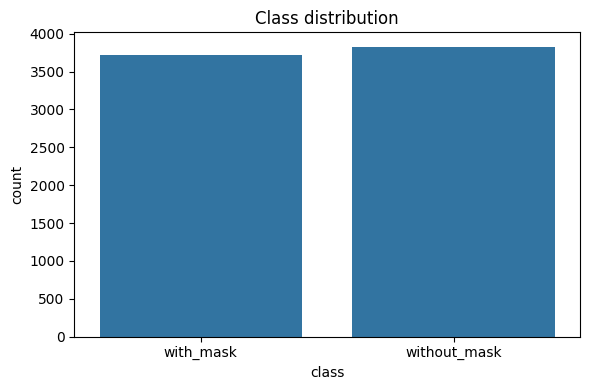

In [ ]:
# Stratified train/val/test split (70/15/15)
# Keeps class proportions consistent across splits.
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)
print('Split sizes:', len(train_df), len(val_df), len(test_df))

# Save split indices for later reuse (avoid data leakage across runs)
train_df.to_csv(REPORTS_DIR / 'train_index.csv', index=False)
val_df.to_csv(REPORTS_DIR / 'val_index.csv', index=False)
test_df.to_csv(REPORTS_DIR / 'test_index.csv', index=False)

# Class balance visualization
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df)
plt.title('Class distribution')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'class_distribution.png')
plt.show()

In [ ]:
# Augmentations and preprocessing
# Transforms aim to improve generalization; normalization follows ImageNet statistics.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),        # resize to model input
    transforms.RandomHorizontalFlip(),              # simple augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # light color jitter
    transforms.ToTensor(),                          # convert PIL→Tensor
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [ ]:
# Dataset and DataLoader
# Simple image dataset using file list from DataFrame.
class ImageListDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tfm=None):
        self.df = df.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path']).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        label = int(row['label'])
        return img, label

# Construct datasets and loaders
train_ds = ImageListDataset(train_df, train_tfms)
val_ds = ImageListDataset(val_df, eval_tfms)
test_ds = ImageListDataset(test_df, eval_tfms)

# Note: pin_memory aids CUDA transfers; NUM_WORKERS=0 is notebook-friendly on macOS
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Sanity check: inspect shape of one batch
next(iter(train_dl))[0].shape

torch.Size([64, 3, 224, 224])

In [ ]:
# Model (Transfer Learning: MobileNetV2)
def create_model(num_classes=2, pretrained=True):
    m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT if pretrained else None)
    in_features = m.classifier[1].in_features
    m.classifier[1] = nn.Linear(in_features, num_classes)
    return m

model = create_model(num_classes=2, pretrained=True)
model.to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable params:', trainable_params)

Trainable params: 2226434


In [ ]:
# Loss, optimizer, scheduler, mixed precision (CUDA only)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [ ]:
# Training and validation loop
def run_epoch(model, loader, train=True):
    model.train(train)
    total_loss = 0.0
    preds, targets = [], []
    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), torch.tensor(yb).to(device)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            out = model(xb)
            loss = criterion(out, yb)
        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        total_loss += loss.item() * xb.size(0)
        preds.extend(out.argmax(1).detach().cpu().numpy().tolist())
        targets.extend(yb.detach().cpu().numpy().tolist())
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc

best_f1 = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = run_epoch(model, train_dl, train=True)
    val_loss, val_acc = run_epoch(model, val_dl, train=False)
    scheduler.step()
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | train_loss={train_loss:.4f} acc={train_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}")
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title('Loss'); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title('Accuracy'); plt.legend()
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'training_curves.png')
plt.show()

KeyboardInterrupt: 

In [ ]:
# Metrics and confusion matrix
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_dl, leave=False):
        xb = xb.to(device)
        out = model(xb)
        all_preds.extend(out.argmax(1).detach().cpu().numpy().tolist())
        all_targets.extend(torch.tensor(yb).detach().cpu().numpy().tolist())
acc = accuracy_score(all_targets, all_preds)
prec = precision_score(all_targets, all_preds, average='macro')
rec = recall_score(all_targets, all_preds, average='macro')
f1 = f1_score(all_targets, all_preds, average='macro')
cm = confusion_matrix(all_targets, all_preds)
print({'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(CLASS_TO_IDX.keys()), yticklabels=list(CLASS_TO_IDX.keys()))
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'confusion_matrix.png')
plt.show()


In [ ]:
# Inference: single image and folder batch
def preprocess_image(path):
    img = Image.open(path).convert('RGB')
    return eval_tfms(img).unsqueeze(0)

@torch.no_grad()
def predict_image(path):
    xb = preprocess_image(path).to(device)
    out = model(xb)
    prob = torch.softmax(out, dim=1)[0].cpu().numpy()
    pred = int(out.argmax(1)[0])
    return {'path': path, 'pred': IDX_TO_CLASS[pred], 'probs': prob.tolist()}

def predict_folder(dir_path):
    results = []
    for name in os.listdir(dir_path):
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            results.append(predict_image(str(Path(dir_path) / name)))
    res_df = pd.DataFrame(results)
    res_df.to_csv(REPORTS_DIR / 'inference_results.csv', index=False)
    return res_df


In [ ]:
# ONNX export and validation via onnxruntime
def export_to_onnx(model, sample_shape=(1,3,IMG_SIZE,IMG_SIZE)):
    model.eval()
    dummy = torch.randn(sample_shape).to(device)
    onnx_path = str(MODELS_DIR / 'mobilenet_v2_mask.onnx')
    torch.onnx.export(
        model,
        dummy,
        onnx_path,
        input_names=['input'],
        output_names=['logits'],
        opset_version=12,
        dynamic_axes={'input': {0: 'batch'}, 'logits': {0: 'batch'}},
    )
    print('Exported ONNX to', onnx_path)
    return onnx_path

def check_onnx(onnx_path):
    sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    dummy = np.random.randn(1,3,IMG_SIZE,IMG_SIZE).astype(np.float32)
    out = sess.run(None, {'input': dummy})[0]
    print('ONNX output shape:', out.shape)

# Example:
# onnx_file = export_to_onnx(model)
# check_onnx(onnx_file)

In [ ]:
# Unit tests (quick checks)
def test_transforms():
    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color=(255, 255, 255))
    t = eval_tfms(img)
    assert t.shape == (3, IMG_SIZE, IMG_SIZE)
    print('Transforms test: OK')

def test_dataset_item():
    if len(train_df) > 0:
        ds = ImageListDataset(train_df.iloc[:10], eval_tfms)
        x, y = ds[0]
        assert isinstance(y, int) and x.shape[0] == 3
        print('Dataset item test: OK')

def test_model_forward():
    xb = torch.randn(2, 3, IMG_SIZE, IMG_SIZE)
    out = model(xb.to(device))
    assert out.shape == (2, 2)
    print('Model forward test: OK')

# Run quick tests (optional)
test_transforms()
test_dataset_item()
test_model_forward()